# Tests

In [1]:
Threads.nthreads()

4

In [2]:
using LinearAlgebra
using Turing
using LimberJack
using PythonCall
using NPZ
using BenchmarkTools;

In [3]:
np = pyimport("numpy");

In [4]:
meta = np.load("../data/DECALS/DECALS_meta.npz")
files = npzread("../data/DECALS/DECALS_files.npz")

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"])
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"]);

In [5]:
path = "/home/jaime/PhD/LimberJack.jl/chains/carlos_chains/cl_cross_corr_v3_DES_K1000_all_mag_correctMag/"
pars = np.loadtxt(string(path, "cl_cross_corr_v3_DES_K1000_all_mag_correctMag.bestfit"))
pars = pyconvert(Vector{Float64}, pars);

In [6]:
fake_cov = cov_tot ./ (sqrt.(diag(cov_tot)) * sqrt.(diag(cov_tot))')

30×30 Matrix{Float64}:
  1.0          -0.0685604    -0.00208283  …  -8.93706e-9  -8.96688e-9
 -0.0685604     1.0          -0.0500614      -7.57469e-9  -7.78348e-9
 -0.00208283   -0.0500614     1.0            -6.98008e-9  -7.14317e-9
  0.0275553    -0.00187172   -7.80379e-5     -8.50502e-7  -8.55021e-7
 -0.00149903    0.0268935    -0.00136412     -6.63296e-7  -6.82409e-7
 -6.22778e-5   -0.00135929    0.0259581   …  -6.57247e-7  -6.73525e-7
 -8.15428e-5   -6.01765e-5   -0.00108624     -5.53185e-7  -5.50985e-7
 -6.66308e-5   -6.76774e-5   -5.18636e-5     -4.7309e-7   -4.49132e-7
 -6.13519e-5   -5.46961e-5   -5.17573e-5     -4.85818e-7  -4.28463e-7
 -5.89764e-5   -4.96895e-5   -4.01327e-5     -5.72469e-7  -4.29581e-7
  0.000104516  -7.24679e-6   -2.98739e-7  …  -8.94135e-5  -8.99108e-5
 -5.6759e-6     0.000103921  -5.1625e-6      -6.74672e-5  -6.94327e-5
 -2.00351e-7   -4.42049e-6    9.71883e-5     -6.32004e-5  -6.4746e-5
  ⋮                                       ⋱               
 -2.09929

In [7]:
fake_inv_cov = pinv(fake_cov)

30×30 Matrix{Float64}:
  1.00552       0.0692163    0.00555857   …   2.70606e-9   2.50341e-9
  0.0692163     1.008        0.0506023        2.96245e-9   2.95773e-9
  0.00555857    0.0506023    1.00322          2.81934e-9   2.91568e-9
 -0.0277571    -0.00154055  -0.000117953     -1.11772e-7  -1.05097e-7
 -0.00190932   -0.0271548   -0.00127423      -1.10938e-7  -1.11576e-7
 -0.000152345  -0.0012781   -0.0261057    …  -1.14276e-7  -1.18814e-7
 -6.70423e-6   -1.09446e-6  -2.87061e-5      -6.25721e-8  -7.24392e-8
 -6.06398e-6    8.46731e-8  -1.50918e-6      -2.78609e-8  -4.6396e-8
 -5.86891e-6    4.13006e-8  -4.8727e-7       -2.60196e-9  -3.0955e-8
 -5.47934e-6    2.09852e-8  -2.66189e-7       2.41191e-8  -2.86298e-9
  0.00136935    7.34584e-5   4.82914e-6   …   2.39295e-6   2.32818e-6
  9.31541e-5    0.00132932   5.57055e-5       2.51193e-6   2.59642e-6
  7.65591e-6    6.47511e-5   0.00129606       2.53921e-6   2.71857e-6
  ⋮                                       ⋱               
 -5.60708e

In [8]:
function get_theory(Ωm, s8;
                 data_vector=data_vector,
                 inv_cov=fake_inv_cov, 
                 tk_mode="emulator")
    
    nuisances = Dict(
                     "DECALS__0_0_b" => pars[28],
                     "DECALS__1_0_b" => pars[29],
                     "DECALS__2_0_b" => pars[30],
                     "DECALS__3_0_b" => pars[31],
                     #"DECALS__0_0_dz" => pars[32],
                     #"DECALS__1_0_dz" => pars[33],
                     #"DECALS__2_0_dz" => pars[34],
                     #"DECALS__3_0_dz" => pars[35]
                     )
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    return theory

end

get_theory (generic function with 1 method)

In [9]:
fake_data = data_vector./sqrt.(diag(cov_tot))

30-element Vector{Float64}:
 20.83383452092093
 26.589992174562404
 31.189692947077432
 19.87460611040377
 24.99346252516561
 30.544710791955406
 35.726379729184174
 36.928574160937714
 41.03508035998337
 43.809846960314076
 19.683871795284787
 26.350918806510737
 30.320631148602708
  ⋮
 52.94558459556325
 19.224338855921015
 25.053253742936683
 30.534074252774452
 33.221454202219014
 38.09087933360444
 39.234288580376784
 43.44152293779922
 45.75145185413217
 51.43761380421683
 56.45180340924266
 62.31506712590762

In [149]:
#ls_tot = []
#for l in 1:length([item for item in keys(files) if occursin("ls", item)])
#    t1, t2 = pairs[l][1], pairs[l][2]
#    append!(ls_tot, files[string("ls_", t1, "_", t2)])
#end
#fake_cov = Diagonal(@.((2*data_vector^2)/((2*ls_tot+1)*0.23)))
#fake_inv_cov = inv(fake_cov)

## 2D Lkl

In [150]:
function get_Xi2(Ωm, s8;
                 data_vector=fake_data,
                 inv_cov=fake_inv_cov, 
                 tk_mode="emulator")
    nuisances = Dict(
                     "DECALS__0_0_b" => pars[28],
                     "DECALS__1_0_b" => pars[29],
                     "DECALS__2_0_b" => pars[30],
                     "DECALS__3_0_b" => pars[31])
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)./sqrt.(diag(cov_tot))
    
    diff = @.(theory-data_vector)
    return dot(diff, inv_cov * diff)

end

get_Xi2 (generic function with 1 method)

In [151]:
get_Xi2(0.3, 0.7)

2628.8443380700055

In [152]:
Ωms = LinRange(0.1, 0.6, 20)
s8s = LinRange(0.60, 0.9, 20)

20-element LinRange{Float64, Int64}:
 0.6,0.615789,0.631579,0.647368,0.663158,…,0.852632,0.868421,0.884211,0.9

In [153]:
Xi2s_emul = zeros(length(Ωms), length(s8s))
Xi2s_EisHu = zeros(length(Ωms), length(s8s))
for i in 1:length(Ωms)
    for j in 1:length(s8s)
        Xi2s_emul[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="emulator")
        Xi2s_EisHu[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="EisHu")
    end
end

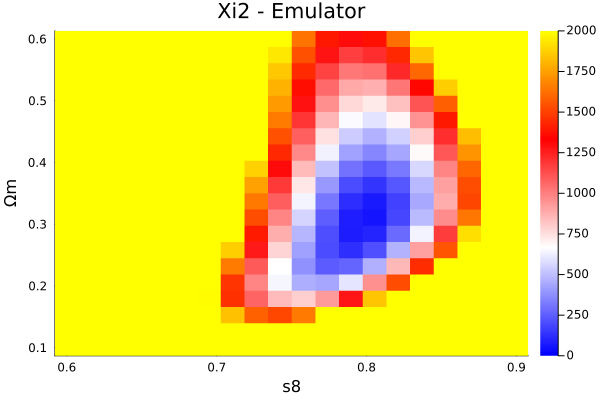

In [154]:
using Plots
gr()
heatmap(s8s, Ωms, Xi2s_emul,
    c=cgrad([:blue, :white,:red, :yellow]),
    ylabel="Ωm", xlabel="s8", clim=(0, 2000),
    title="Xi2 - Emulator")

## Turing

In [159]:
using Turing
@model function model(data_vector;
                      tracers_names=tracers_names,
                      pairs=pairs,
                      idx=idx,
                      cov=fake_cov, 
                      files=files)
 
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.6)
    Ωb = 0.05 #~ Uniform(0.028, 0.065)
    h = 0.67 #~ Uniform(0.64, 0.82)
    s8 ~ Uniform(0.6, 0.9)
    ns = 0.81 #~ Uniform(0.84, 1.1)
    
    DECALS__0_0_b = 1.166 #~ Uniform(0.8, 3.0)
    DECALS__1_0_b = 1.399 #~ Uniform(0.8, 3.0)
    DECALS__2_0_b = 1.349 #~ Uniform(0.8, 3.0)
    DECALS__3_0_b = 1.823 #~ Uniform(0.8, 3.0)

    nuisances = Dict(
                     "DECALS__0_0_b" => DECALS__0_0_b,
                     "DECALS__1_0_b" => DECALS__1_0_b,
                     "DECALS__2_0_b" => DECALS__2_0_b,
                     "DECALS__3_0_b" => DECALS__3_0_b)

    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8,
                                     tk_mode="emulator",
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    data_vector ~ MvNormal(theory./sqrt.(diag(cov_tot)) , cov)
end;

In [164]:
cycles = 6
steps = 50
iterations = 100
TAP = 0.90
adaptation = 300
init_ϵ = 10^-7

1.0000000000000004e-7

In [165]:
chain = sample(model(fake_data), NUTS(adaptation, TAP, init_ϵ=init_ϵ),
                     iterations, progress=true; save_state=true)

Sampling: 100%|█████████████████████████████████████████| Time: 1:22:47


LoadError: EOFError: read end of file

In [166]:
chain

LoadError: UndefVarError: chain not defined